# Timoshenk Beam Example
![timoshenko_beam_figure.png](../img/timoshenko_beam_figure.png)

In [1]:
import numpy as np

# pyelastica modules
from elastica.modules import BaseSystemCollection, Constraints, Forcing, Damping, CallBacks

# import cosserat rod class
from elastica.rod.cosserat_rod import CosseratRod

# import damping class
from elastica.dissipation import AnalyticalLinearDamper

# import boundary condition class
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces

# import timestepping
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate

# import callback class
from elastica.callback_functions import CallBackBaseClass
from collections import defaultdict

# Setup Beam Class

In [2]:
class TimoshenkoBeamSimulator(BaseSystemCollection, Constraints, CallBacks, Forcing, Damping):
    pass

timoshenko_sim = TimoshenkoBeamSimulator()

# Define material ppts

In [3]:
# setting up test params
n_elem = 100

density = 1000
nu = 1e-4
E = 1e6
# For shear modulus of 1e4, nu is 99!
poisson_ratio = 99 # physically impossible, but for example purposes
shear_modulus = E / (poisson_ratio + 1.0)

start = np.zeros((3,))
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
base_length = 3.0
base_radius = 0.25
base_area = np.pi * base_radius ** 2

# Create shearable rod

In [4]:
shearable_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    shear_modulus=shear_modulus,
)
timoshenko_sim.append(shearable_rod)

# Add damping

In [5]:
dl = base_length / n_elem
dt = 0.01 * dl
timoshenko_sim.dampen(shearable_rod).using(AnalyticalLinearDamper, damping_constant=nu, time_step=dt)

# Add constraints

## 1. Left hand end of the rod is fixed to the ground

In [6]:
timoshenko_sim.constrain(shearable_rod).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)
print("One end of the rod is now fixed in place")

One end of the rod is now fixed in place


## 2. Constrain the input force to be at the distal end only

In [7]:
origin_force = np.zeros((3,))
end_force = np.array([-100, 0, 0])
ramp_up_time = 5.0

timoshenko_sim.add_forcing_to(shearable_rod).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)

# Create unshearable rod

In [8]:
# Start into the plane
unshearable_start = np.array([0.0, -1.0, 0.0])
unshearable_rod = CosseratRod.straight_rod(
    n_elem,
    unshearable_start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    # Unshearable rod needs G -> inf, which is achievable with a poisson ratio of -1.0
    shear_modulus=E / (-0.85 + 1.0),
)

timoshenko_sim.append(unshearable_rod)

timoshenko_sim.dampen(unshearable_rod).using(
    AnalyticalLinearDamper,
    damping_constant=nu,
    time_step=dt,
)

timoshenko_sim.constrain(unshearable_rod).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)

timoshenko_sim.add_forcing_to(unshearable_rod).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)
print("Unshearable rod set up")

Unshearable rod set up


# Finalise sys

# Define simulation time

In [9]:
final_time = 30.0
total_steps = int(final_time / dt)
print(f"Total steps: {total_steps:d}")
timestepper = PositionVerlet()

Total steps: 100000


In [10]:
# Add call backs
class TimoshenkoCallback(CallBackBaseClass):
    """
    Call back function for continuum snake
    """

    def __init__(self, step_skip: int, callback_params: dict):
        CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):

        if current_step % self.every == 0:

            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position"].append(system.position_collection.copy())


            return
        
pp_list = defaultdict(list)
timoshenko_sim.collect_diagnostics(shearable_rod).using(
    TimoshenkoCallback, step_skip=100, callback_params=pp_list
)


In [11]:
timoshenko_sim.finalize()
print("Simulation set up")

Simulation set up


# Run simulation

In [12]:
integrate(timestepper, timoshenko_sim, final_time, total_steps)

100%|██████████| 100000/100000 [00:08<00:00, 12161.43it/s]

Final time of simulation is :  30.000000000107015


30.000000000107015

# Post-processing Results

In [13]:
# Compute beam position for sherable and unsherable beams.
def analytical_result(arg_rod, arg_end_force, shearing=True, n_elem=500):
    base_length = np.sum(arg_rod.rest_lengths)
    arg_s = np.linspace(0.0, base_length, n_elem)
    if type(arg_end_force) is np.ndarray:
        acting_force = arg_end_force[np.nonzero(arg_end_force)]
    else:
        acting_force = arg_end_force
    acting_force = np.abs(acting_force)
    linear_prefactor = -acting_force / arg_rod.shear_matrix[0, 0, 0]
    quadratic_prefactor = (
        -acting_force
        / 2.0
        * np.sum(arg_rod.rest_lengths / arg_rod.bend_matrix[0, 0, 0])
    )
    cubic_prefactor = (acting_force / 6.0) / arg_rod.bend_matrix[0, 0, 0]
    if shearing:
        return (
            arg_s,
            arg_s * linear_prefactor
            + arg_s ** 2 * quadratic_prefactor
            + arg_s ** 3 * cubic_prefactor,
        )
    else:
        return arg_s, arg_s ** 2 * quadratic_prefactor + arg_s ** 3 * cubic_prefactor

## Plotting

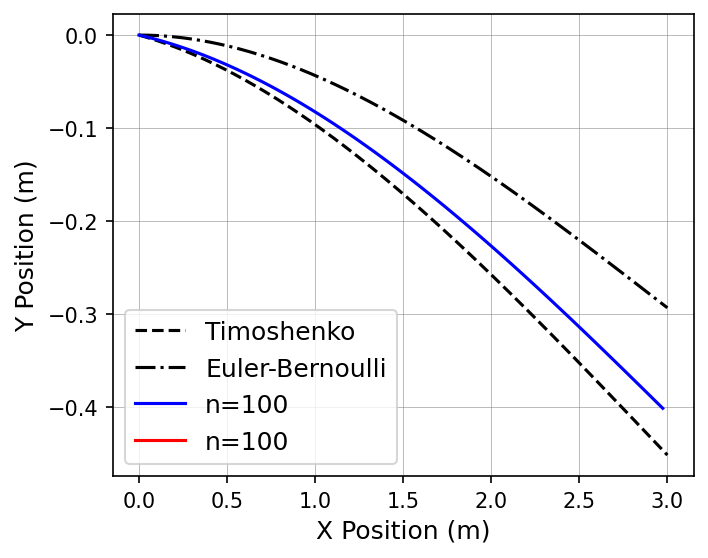

In [14]:
def plot_timoshenko(shearable_rod, unshearable_rod, end_force):
    import matplotlib.pyplot as plt

    analytical_shearable_positon = analytical_result(
        shearable_rod, end_force, shearing=True
    )
    analytical_unshearable_positon = analytical_result(
        unshearable_rod, end_force, shearing=False
    )

    fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    ax.grid(which="major", color="grey", linestyle="-", linewidth=0.25)

    ax.plot(
        analytical_shearable_positon[0],
        analytical_shearable_positon[1],
        "k--",
        label="Timoshenko",
    )
    ax.plot(
        analytical_unshearable_positon[0],
        analytical_unshearable_positon[1],
        "k-.",
        label="Euler-Bernoulli",
    )

    ax.plot(
        shearable_rod.position_collection[2, :],
        shearable_rod.position_collection[0, :],
        "b-",
        label="n=" + str(shearable_rod.n_elems),
    )
    ax.plot(
        unshearable_rod.position_collection[2, :],
        unshearable_rod.position_collection[0, :],
        "r-",
        label="n=" + str(unshearable_rod.n_elems),
    )

    ax.legend(prop={"size": 12})
    ax.set_ylabel("Y Position (m)", fontsize=12)
    ax.set_xlabel("X Position (m)", fontsize=12)
    plt.show()


plot_timoshenko(shearable_rod, unshearable_rod, end_force)

# Dynamic Plotting

In [15]:
time = 0.0


class BeamSimulator(BaseSystemCollection, Constraints, Forcing, Damping):
    pass


dynamic_update_sim = BeamSimulator()

shearable_rod_new = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    shear_modulus=shear_modulus,
)
dynamic_update_sim.append(shearable_rod_new)
dynamic_update_sim.dampen(shearable_rod_new).using(
    AnalyticalLinearDamper,
    damping_constant=nu,
    time_step=dt,
)
dynamic_update_sim.constrain(shearable_rod_new).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)
dynamic_update_sim.add_forcing_to(shearable_rod_new).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)

unshearable_rod_new = CosseratRod.straight_rod(
    n_elem,
    unshearable_start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    # Unshearable rod needs G -> inf, which is achievable with a poisson ratio of -1.0
    shear_modulus=E / (-0.85 + 1.0),
)
dynamic_update_sim.append(unshearable_rod_new)
dynamic_update_sim.dampen(unshearable_rod_new).using(
    AnalyticalLinearDamper,
    damping_constant=nu,
    time_step=dt,
)
dynamic_update_sim.constrain(unshearable_rod_new).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)
dynamic_update_sim.add_forcing_to(unshearable_rod_new).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)

dynamic_update_sim.finalize()


def run_and_update_plot(simulator, dt, start_time, stop_time, ax):
    from elastica.timestepper import extend_stepper_interface
    from elastica.timestepper.symplectic_steppers import PositionVerlet

    timestepper = PositionVerlet()
    do_step, stages_and_updates = extend_stepper_interface(timestepper, simulator)

    n_steps = int((stop_time - start_time) / dt)
    time = start_time
    for i in range(n_steps):
        time = do_step(timestepper, stages_and_updates, simulator, time, dt)
    plot_timoshenko_dynamic(shearable_rod_new, unshearable_rod_new, end_force, time, ax)
    return time


def plot_timoshenko_dynamic(shearable_rod, unshearable_rod, end_force, time, ax):
    import matplotlib.pyplot as plt
    from IPython import display

    analytical_shearable_positon = analytical_result(
        shearable_rod, end_force, shearing=True
    )
    analytical_unshearable_positon = analytical_result(
        unshearable_rod, end_force, shearing=False
    )

    ax.clear()
    ax.grid(which="major", color="grey", linestyle="-", linewidth=0.25)
    ax.plot(
        analytical_shearable_positon[0],
        analytical_shearable_positon[1],
        "k--",
        label="Timoshenko",
    )
    ax.plot(
        analytical_unshearable_positon[0],
        analytical_unshearable_positon[1],
        "k-.",
        label="Euler-Bernoulli",
    )

    ax.plot(
        shearable_rod.position_collection[2, :],
        shearable_rod.position_collection[0, :],
        "b-",
        label="shearable rod",
    )
    ax.plot(
        unshearable_rod.position_collection[2, :],
        unshearable_rod.position_collection[0, :],
        "r-",
        label="unshearable rod",
    )

    ax.legend(prop={"size": 12}, loc="lower left")
    ax.set_ylabel("Y Position (m)", fontsize=12)
    ax.set_xlabel("X Position (m)", fontsize=12)
    ax.set_title("Simulation Time: %0.2f seconds" % time)
    ax.set_xlim([-0.1, 3.1])
    ax.set_ylim([-0.045, 0.002])

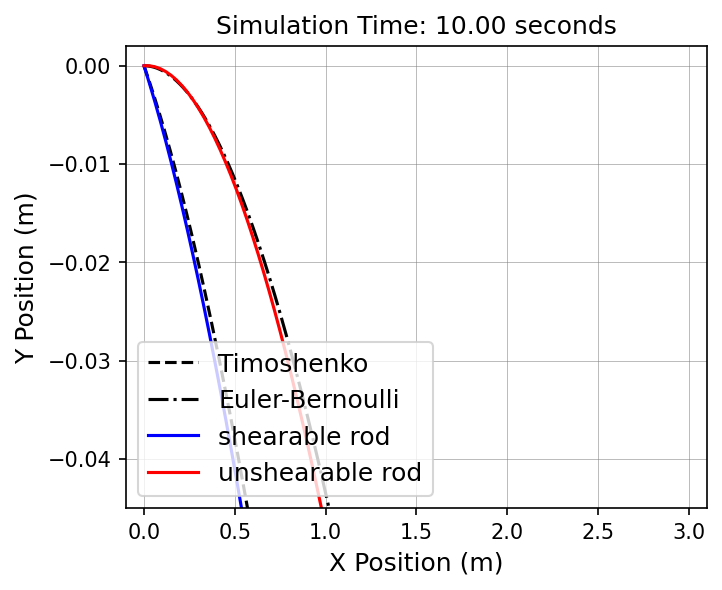

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

evolve_for_time = 10.0
update_interval = 1.0e-1

# update the plot every 1 second
fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
ax = fig.add_subplot(111)
first_interval_time = update_interval + time
last_interval_time = time + evolve_for_time
for stop_time in np.arange(
    first_interval_time, last_interval_time + dt, update_interval
):
    time = run_and_update_plot(dynamic_update_sim, dt, time, stop_time, ax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

In [17]:
from IPython.display import Video
from tqdm import tqdm


def plot_video_2D(plot_params: dict, video_name="video.mp4", margin=0.2, fps=15):
    from matplotlib import pyplot as plt
    import matplotlib.animation as manimation

    t = np.array(plot_params["time"])
    positions_over_time = np.array(plot_params["position"])
    total_time = int(np.around(t[..., -1], 1))
    total_frames = fps * total_time
    step = round(len(t) / total_frames)

    print("creating video -- this can take a few minutes")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.axis("equal")
    rod_lines_2d = ax.plot(
        positions_over_time[0][2], positions_over_time[0][0], linewidth=3
    )[0]
    ax.set_xlim([0 - margin, 3 + margin])
    ax.set_ylim([-1.5 - margin, 1.5 + margin])
    with writer.saving(fig, video_name, dpi=100):
        with plt.style.context("seaborn-whitegrid"):
            print(len(t), " len(t)")
            print(total_time, " total_time")
            print(total_frames, " total_frames")
            print("step size: ", step, " len(t) / total_frames")
            for time in range(1, len(t), step):
                rod_lines_2d.set_xdata(positions_over_time[time][2])
                rod_lines_2d.set_ydata(positions_over_time[time][0])

                writer.grab_frame()
    plt.close(fig)

filename = "timoshenko_beam.mp4"
plot_video_2D(pp_list, filename, margin=0.2, fps=30)

Video(filename)

creating video -- this can take a few minutes
1001  len(t)
30  total_time
900  total_frames
step size:  1  len(t) / total_frames
